## Project Phase 2 - Jack Scantlebury

In [12]:
%matplotlib inline

In [13]:
import numpy as np
from numpy import array
import pyopencl as cl
import os
import time
import sys
import matplotlib
import scipy.sparse.linalg as spla
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from IPython.display import HTML
import matplotlib.animation as animation
import itertools

In [14]:
os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1' # More compiler info

"""
 Do you want to run all renderings and longer calculations?
 True: short runtime
 False: long (several hours) runtime.

 'True' also disables finer mesh calculations which
 will cause errors without the requisite vtk files.
"""
MARKING_VERSION = True 

In [15]:
# Utility functions
class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    except Exception:
        print('is_number(s) error! Terminating.')
        exit()

The FiniteElementMesh class from Phase I is reused to load the VTK file and calculate some of the information (like integration elements and inverse transposed Jacobians) for use later.

In [16]:
class FiniteElementMesh(object):
    """A Grid class that can handle two dimensional flat and surface grids."""
    vertex_arr = []
    element_arr = []
    dtype = -1
    jacobians = -1
    inverse_transpose_jacobians = -1
    integration_elements = -1
    # C type names are different from numpy types. Will be modified in __init__
    # to 'float' or 'double'. Used in miko templating.
    ctype = -1

    def __init__(self, vertices, elements, dtype='float32'):
        """
        Initialize a grid.

        Parameters
        ----------
        vertices: (N, 3) Array
            Vertices are stored in an (N, 3) array of floating point numbers.
        elements: (N, 3) Array
            Elements are stored in an (N, 3) array of type 'np.int32'.
        dtype: string
          dtype is either 'float64' or 'float32'. Internally, all structures and the
          vertices are converted to the format specified by 'dtype'. This is useful
          for OpenCL computations on GPUs that do not properly support double precision
          ('float64') types
        """
        self.vertex_arr = vertices.astype(dtype)
        self.element_arr = elements
        self.dtype = dtype

        # C uses different type names; mako uses ctype for variable templating.
        if dtype == 'float32':
            self.ctype = 'float'
        elif dtype == 'float64':
            self.ctype = 'double'

        # Calculate the jacobian, inverse transpose jacobian and integration elements for all elements and store as np arrays
        elements = list(range(len(self.elements)))
        n = len(elements)
        points = []
        for element in elements:
            try:
                coords = self.corners(element)
                points.append(coords[0][0])
                points.append(coords[0][1])
                points.append(coords[1][0])
                points.append(coords[1][1])
                points.append(coords[2][0])
                points.append(coords[2][1])
            except IndexError:
                print('Grid.jacobian is only valid for elements with 3 nodes.',
                      'Returning -1.')
                return -1
        points = np.array(points).astype(self.dtype)
        ctx = cl.create_some_context()
        queue = cl.CommandQueue(ctx)
        mf = cl.mem_flags
        points_arr = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                               hostbuf=points)
        kernel_template = """
        __kernel void inverse_jacobian_transpose(__global const {0} *points_arr,
                          __global {0} *jacobians,
                          __global {0} *itj, __global {0} *ies){{

            const int global_idx = get_global_id(0); //get position in array

            const int res_idx = global_idx*4; //get matrix 'block' in array
            const int points_idx = global_idx*6; //get coordinate 'block' in array

            // Each jacobian calculated in series
            jacobians[res_idx] = points_arr[points_idx + 2] - points_arr[points_idx];
            jacobians[res_idx + 1] = points_arr[points_idx + 4] - points_arr[points_idx];
            jacobians[res_idx + 2] = points_arr[points_idx + 3] - points_arr[points_idx + 1];
            jacobians[res_idx + 3] = points_arr[points_idx + 5] - points_arr[points_idx + 1];

            // Determinant can be safely calculated due to lack of parallelism within jacobians
            const {0} det = jacobians[res_idx]*jacobians[res_idx+3]
            - jacobians[res_idx+1]*jacobians[res_idx+2];

            // Inverse tranpose Jacobian can be calculated with information retrieved from jacobians array
            itj[res_idx] = jacobians[res_idx + 3]/det;
            itj[res_idx+1] = -jacobians[res_idx + 2]/det;
            itj[res_idx+2] = -jacobians[res_idx + 1]/det;
            itj[res_idx+3] = jacobians[res_idx]/det;

            // No standard library available in kernel, so no abs() function
            if(det < 0){{
                ies[global_idx] = -det;
            }} else {{
                ies[global_idx] = det;
            }}
        }}
        """

        kernel = kernel_template.format(self.ctype)
        prg = cl.Program(ctx, kernel).build()

        # Empty arrays for finding the size of output buffers
        size_array = np.zeros((4 * n), dtype=self.dtype)
        size_array_ie = np.zeros(n, dtype=self.dtype)

        # Buffers for reading output of the kernel
        ie_device = cl.Buffer(ctx, mf.WRITE_ONLY, size_array_ie.nbytes)
        itj_device = cl.Buffer(ctx, mf.WRITE_ONLY, size_array.nbytes)
        j_device = cl.Buffer(ctx, mf.WRITE_ONLY, size_array.nbytes)

        # Calling the kernel function; n/4 workgroups of size 4 for n elements
        prg.inverse_jacobian_transpose(queue, (n,), None, points_arr,
                                       j_device, itj_device, ie_device)

        # Allocation of memory to class variables for storage of results for later access
        self.inverse_transpose_jacobians = np.empty_like(size_array)
        self.jacobians = np.empty_like(size_array)
        self.integration_elements = np.empty_like(size_array_ie)

        # Reading the buffers into class variables
        cl.enqueue_copy(queue, self.jacobians, j_device)
        cl.enqueue_copy(queue, self.inverse_transpose_jacobians, itj_device)
        cl.enqueue_copy(queue, self.integration_elements, ie_device)

        # Reshaping the 1D numpy arrays
        self.jacobians = self.jacobians.reshape(n, 2, 2)
        self.inverse_transpose_jacobians = self.inverse_transpose_jacobians.reshape(n, 2, 2)

    @property
    def vertices(self):
        """Return the vertices."""
        return self.vertex_arr

    @property
    def elements(self):
        """Return the elemenets."""
        return self.element_arr

    def corners(self, element_index):
        """Return the corners of a given element as (3, 3) array"""
        ele = self.element_arr[element_index]
        result = []
        for point in ele:
            for coord in self.vertex_arr[point]:
                result.append(coord)
        return array(result).reshape(len(ele), 3)

    def integration_element(self, element_index):
        """Return |det J| for a given element."""
        return self.integration_elements[element_index]

    def normal(self, element_index):
        """Return the exterior pointing normal of an element."""
        points = self.corners(element_index)
        if len(points) > 2:
            return np.cross(points[1] - points[0], points[2] - points[1])
        else:
            print('Not enough vectors to calculate normal')
            return -1

    def inverse_jacobian_transpose(self, element_index):
        """Return the (2, 2) inverse Jacobian transpose of an element."""
        return self.inverse_transpose_jacobians[element_index]

    def jacobian(self, element_index):
        """Return the (2, 2) Jacobian of an element."""
        return self.jacobians[element_index]

    @classmethod
    def from_file(cls, file_name, constructor_dtype='float32'):
        """Read a mesh from a vtk file."""
        with open(file_name) as f:
            # Flags so that we know when to read into vertices and elements
            points_flag = False
            cells_flag = False
            vertices = []
            elements = []
            for idx, line in enumerate(f.readlines()):
                if idx > 3:  # Ignore preamble which may trigger flags by accident
                    if line.lower().find('points') != -1:
                        points_flag = True
                        cells_flag = False
                    elif line.lower().find('cells') != -1:
                        points_flag = False
                        cells_flag = True
                    try:
                        line.split()[0]
                    except IndexError:
                        pass  # Blank line, ignore
                    else:
                        if is_number(line.split()[0]):
                            if points_flag:
                                vertices.append([line.split()[0],
                                                 line.split()[1],
                                                 line.split()[2]])
                            elif cells_flag:
                                if len(line.split()) == 4:
                                    cell = []
                                    for i, d in enumerate(line.split()):
                                        if i > 0:
                                            cell.append(np.int32(d))  # Vertex indices must be integers
                                    elements.append(cell)

        # Convert lists to numpy arrays of appropriate types for faster lookup
        vertices = array(vertices).astype(constructor_dtype)
        elements = array(elements)
        return cls(vertices, elements, dtype=constructor_dtype)

The ```FiniteElementSolver``` class below is initialised with a mesh and some properties from the ```FiniteElementMesh``` class above. It has 10 methods, 3 of which are somewhat redundant and were used for prototyping (```PyGlobalMatVec```, ```PyLinearOperator``` and ```PyLocalStiffnessMatrix```). They will, however, be used for benchmarking.

Below is presented a table of class methods and a brief description of their functionality:

| Method     | Description   |
|:-------------:|:-------------|
|```__init__(self, VTKFilename, dtype='float32')```     | Initialisation; Instance of FiniteElementMesh stored in ```Mesh``` class variable and generated using ```VTKFilename```. Class variables ```ctype``` and ```dtype``` initliased to maintain type consistency. |
| ```MatrixVectorProduct(self, x)``` | Used later as ```SciPy LinearOperator```; takes a vector ```x``` and calculates 'matrix-free' MatVec product. More details below. |
| ```LinearOperator(self, x)``` | Creates ```SciPy LinearOperator``` object using ```MatrixVectorProduct``` method for use in conjugate gradient when solving for ```x```.      |
| ```new_rhs(self, f)``` | Assembles the load vector using the integration elements calculated by ```FiniteElementMesh``` and the function ```f(x, y)```. More details below.      |
| ```GetGlobalStiffnessMatrix(self)``` | Returns an explicit form of the matrix ```A```, assembled by ```LinearOperator```. Can take up to a minute to calculate using ```NumPy``` vector operations. |
| ```PyLocalStiffnessMatrix(self, element)``` | Uses ```NumPy``` operations to find the local stiffness matrix given an element ID. |
| ```PyGlobalMatVec(self, GlobalX)``` | Uses ```NumPy``` operations to do a MatVec operation given a vector ```x```. |
| ```PyLinearOperator(self)``` | Returns a ```SciPy LinearOperator``` object which uses ```PyGlobalMatVec``` to perform a MatVec operation. |
| ```CGSolve(self, tol, opencl=True)``` | Solves and saves the finite element system to within a tolerance ```tol``` using either the ```NumPy``` (```opencl=False```) or OpenCL (```opencl=True```) class methods. |
| ```Plot(self, tol, f, opencl=True)``` | Plots the results of ```CGSolve``` in 3d. |
| ```plot_2d(self, tol, f, opencl=True)``` | Plots the results of ```CGSolve``` in 2d. |
| ```phase_3(self, u0, dt, n_iters, ocl=False)``` | Calculates the evolution of ```u``` with time. |

The phase 3 method is not particularly fast, because the summing of the local contributions into the global MatVec product must be done in series to avoid race conditions.

In [17]:
class FiniteElementSolver:
    dtype = -1
    ctype = -1
    Mesh = -1
    K = -1
    Solution = -1
    blen = -1
    f = -1

    def __init__(self, VTKFilename, dtype='float32'):
        self.dtype = dtype
        if self.dtype == 'float32':
            self.ctype = 'float'
        else:
            self.ctype = 'double'
        self.Mesh = FiniteElementMesh.from_file(VTKFilename, self.dtype)
        self.bcs = self.FindBoundaryNodes()
        self.blen = len(self.bcs)
        self.central_node = self.find_target(0.5, 0.5)

    def MatrixVectorProduct(self, x):
        """Implement kernel based matrix vector product here"""
        kernel_template = """

        __kernel void MatVec(__global const {0} *ij00_arr, __global const {0} *ij01_arr,
                             __global const {0} *ij10_arr, __global const {0} *ij11_arr,
                          __global {0} *ie_arr, __global {0} *x_arr,
                          __global int *map_arr, __global {0} *result_arr){{

            const int Index = get_global_id(0);
            const int PtsIdx = 3*Index;
            const int Points[3] = {{ map_arr[PtsIdx], map_arr[PtsIdx + 1],
                                    map_arr[PtsIdx + 2] }};

            {0} A[9];
            const {0} ij00 = ij00_arr[Index];
            const {0} ij01 = ij01_arr[Index];
            const {0} ij10 = ij10_arr[Index];
            const {0} ij11 = ij11_arr[Index];
            const {0} IntegrationElement = ie_arr[Index];
            const int Grads[3][2] = {{ {{ -1, -1 }}, {{ 1, 0 }}, {{ 0, 1 }} }};

            for(int i=0; i<3; ++i){{
                for(int j=0; j<3; ++j){{
                    const int AIndex = i*3 + j;
                    {0} LHS[2];
                    {0} RHS[2];
                    LHS[0] = ij00*Grads[i][0] + ij01*Grads[i][1];
                    LHS[1] = ij10*Grads[i][0] + ij11*Grads[i][1];
                    RHS[0] = ij00*Grads[j][0] + ij01*Grads[j][1];
                    RHS[1] = ij10*Grads[j][0] + ij11*Grads[j][1];
                    const {0} InnerProduct = LHS[0]*RHS[0] + LHS[1]*RHS[1];
                    A[AIndex] = IntegrationElement*InnerProduct;
                }}
            }}
            
            for(int i=0; i<3; ++i){{
                {0} acc = 0.0;
                for(int j=0; j<3; ++j){{
                    acc += A[i*3 + j]*x_arr[Points[j]];
                }}
                result_arr[3*Index + i] = acc;
            }}
        }}
        """
        ctx = cl.create_some_context()
        queue = cl.CommandQueue(ctx)
        mf = cl.mem_flags
        x = x.astype(self.dtype)
        map_arr = self.Mesh.element_arr.flatten().astype('int32')
        ij1 = self.Mesh.inverse_transpose_jacobians[:, 0, 0].astype(self.dtype)
        ij2 = self.Mesh.inverse_transpose_jacobians[:, 0, 1].astype(self.dtype)
        ij3 = self.Mesh.inverse_transpose_jacobians[:, 1, 0].astype(self.dtype)
        ij4 = self.Mesh.inverse_transpose_jacobians[:, 1, 1].astype(self.dtype)
        ie = self.Mesh.integration_elements.astype(self.dtype)
        ij_device1 = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                               hostbuf=ij1)
        ij_device2 = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                               hostbuf=ij2)
        ij_device3 = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                               hostbuf=ij3)
        ij_device4 = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                               hostbuf=ij4)
        ie_device = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                              hostbuf=ie)
        x_device = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                             hostbuf=x)
        map_device = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                               hostbuf=map_arr)
        n = 3 * len(ie)

        kernel = kernel_template.format(self.ctype)
        prg = cl.Program(ctx, kernel).build()

        # Empty arrays for finding the size of output buffers
        size_array = np.zeros((n), dtype=self.dtype)

        # Buffers for reading output of the kernel
        result_buffer = cl.Buffer(ctx, mf.READ_WRITE, size_array.nbytes)

        # Calling the kernel function; n/4 workgroups of size 4 for n elements
        prg.MatVec(queue, (len(ie),), (1,), ij_device1, ij_device2, ij_device3,
                   ij_device4, ie_device, x_device, map_device, result_buffer).wait()

        cl.enqueue_copy(queue, size_array, result_buffer)

        # Allocation of memory to class variables for storage of results for later access
        Ysize = np.zeros((len(self.Mesh.vertices), 1)).astype(self.dtype)
        Y = np.empty_like(Ysize)
        final_buffer = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR,
                               hostbuf=Ysize)

        sum_y_kernel = """
            __kernel void sumY(__global {0} *result_buffer, __global int *map_arr,
                                 __global {0} *final_buffer){{
                for(int resultIdx=0; resultIdx<{1}; ++resultIdx){{
                    for(int i=0; i<3; i++){{
                        if(map_arr[3*resultIdx + i] >= {2}){{
                            final_buffer[map_arr[3*resultIdx + i]] += result_buffer[3*resultIdx + i];
                        }}
                    }}
                }}
            }}
        """
        sum_y_kernel = sum_y_kernel.format(self.ctype, str(len(self.Mesh.element_arr)), str(self.blen))
        prg = cl.Program(ctx, sum_y_kernel).build()
        prg.sumY(queue, (1,), (1,), result_buffer, map_device, final_buffer)

        # Reading the buffers into class variables
        cl.enqueue_copy(queue, Y, final_buffer)
        return Y

    def LinearOperator(self):
        """Create a SciPy LinearOperator object from your kernel. A LinearOperator takes a vector x and returns the
        matrix vector product Ax"""
        n = len(self.Mesh.vertices)
        A = spla.LinearOperator((n, n), self.MatrixVectorProduct)
        return A
    
    def GetGlobalStiffnessMatrix(self):
        if self.K == -1:
            self.K = self.LinearOperator().matmat(np.identity(len(self.Mesh.vertex_arr)))
        return self.K

    def PyLocalStiffnessMatrix(self, element):
        A = np.zeros((3, 3), dtype=self.dtype)
        grad1 = np.array([[-1], [-1]], dtype=self.dtype)
        grad2 = np.array([[1], [0]], dtype=self.dtype)
        grad3 = np.array([[0], [1]], dtype=self.dtype)  # CHECK PHI2 AND PHI3
        grads = [grad1, grad2, grad3]
        InverseJacobian = self.Mesh.inverse_jacobian_transpose(element)
        IntegrationElement = self.Mesh.integration_element(element)
        for i in range(3):
            for j in range(3):
                LHS = np.dot(InverseJacobian, grads[i]).transpose()
                RHS = np.dot(InverseJacobian, grads[j]).transpose()
                A[i, j] = IntegrationElement * np.inner(LHS, RHS)
        return A

    def PyGlobalMatVec(self, GlobalX):
        GlobalY = np.zeros((len(GlobalX), 1))
        for Index, Element in enumerate(self.Mesh.elements):
            A = self.PyLocalStiffnessMatrix(Index)
            LocalX = np.array([GlobalX[Element[0]], GlobalX[Element[1]],
                               GlobalX[Element[2]]])
            LocalY = np.dot(A, LocalX)
            GlobalY[Element[0]] += LocalY[0]
            GlobalY[Element[1]] += LocalY[1]
            GlobalY[Element[2]] += LocalY[2]
        for i in range(self.blen):
            GlobalY[i] = GlobalX[i]
        return GlobalY
    
    def PyLinearOperator(self):
        n = len(self.Mesh.vertices)
        A = spla.LinearOperator((n, n), self.PyGlobalMatVec)
        return A
    
    def CGSolve(self, tol, f=-1, opencl=True, suppress=False):
        self.pt_history = []
        self.cg_history = []
        if type(f) == int:
            f = np.ones((len(self.Mesh.vertex_arr), 1)).astype(self.dtype)
        rhs = self.new_rhs(f).squeeze()
        def solve_sparse(A, b):
            num_iters = 0

            def callback(xk):
                nonlocal num_iters
                num_iters += 1
                s = ' '*(5-len(str(num_iters)))
                if not suppress: # For benchmarking, repeated unncessary use of matvec will distort results
                    res = np.linalg.norm(A.matvec(xk) - b)
                    sys.stdout.write("\rNorm of residual at iteration " + s + str(num_iters) +
                                     ': ' + str(res))
                    sys.stdout.flush()
                    self.cg_history.append(res)
                self.pt_history.append(np.abs(xk[self.central_node] - 0.0655213460943))

            x, status = spla.cg(A, b, tol=tol, callback=callback, maxiter=5000)
            if not suppress:
                print('\n')
            return x, status, num_iters
        Method = self.LinearOperator() if opencl else self.PyLinearOperator()
        x, exit_status, iters = solve_sparse(Method, rhs)
        if not suppress:
            print('Exit status:', exit_status)
            print('Iterations: ', iters)
        return x.reshape((len(x)))
    
    def new_rhs(self, f):
        """Implement kernel based matrix vector product here"""
        ctx = cl.create_some_context()
        queue = cl.CommandQueue(ctx)
        mf = cl.mem_flags
        f = f.astype(self.dtype)
        map_arr = self.Mesh.element_arr.flatten().astype(self.dtype)
        ij1 = self.Mesh.inverse_transpose_jacobians[:, 0, 0].astype(self.dtype)
        ij2 = self.Mesh.inverse_transpose_jacobians[:, 0, 1].astype(self.dtype)
        ij3 = self.Mesh.inverse_transpose_jacobians[:, 1, 0].astype(self.dtype)
        ij4 = self.Mesh.inverse_transpose_jacobians[:, 1, 1].astype(self.dtype)
        ie = self.Mesh.integration_elements.astype(self.dtype)
        ij_device1 = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                               hostbuf=ij1)
        ij_device2 = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                               hostbuf=ij2)
        ij_device3 = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                               hostbuf=ij3)
        ij_device4 = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                               hostbuf=ij4)
        ie_device = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                              hostbuf=ie)
        f_device = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                             hostbuf=f)
        map_device = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                               hostbuf=map_arr)
        kernel_template = """

        __kernel void rhs(__global const {0} *ij00_arr, __global const {0} *ij01_arr,
                             __global const {0} *ij10_arr, __global const {0} *ij11_arr,
                          __global {0} *ie_arr, __global {0} *x_arr,
                          __global {0} *map_arr, __global {0} *result_arr){{

            const int Index = get_global_id(0);
            const int PtsIdx = 3*Index;
            const int Points[3] = {{ map_arr[PtsIdx], map_arr[PtsIdx + 1],
                                    map_arr[PtsIdx + 2] }};

            {0} M[9] = {{ 2, 1, 1, 1, 2, 1, 1, 1, 2 }};
            for(int i=0; i<9; ++i){{
                M[i] = M[i]/({0})(24);
            }}
            const {0} IntegrationElement = ie_arr[Index];

            for(int i=0; i<3; ++i){{
                {0} acc = 0.0;
                for(int j=0; j<3; ++j){{
                    acc += M[i*3 + j]*x_arr[Points[j]];
                    //result_arr[3*Index + i] = M[i*j];
                }}
                result_arr[3*Index + i] = IntegrationElement*acc;
                
            }}
        }}
        """
        n = 3 * len(ie)
        kernel = kernel_template.format(self.ctype)
        prg = cl.Program(ctx, kernel).build()

        # Empty arrays for finding the size of output buffers
        size_array = np.zeros((n), dtype=self.dtype)

        # Buffers for reading output of the kernel
        result_buffer = cl.Buffer(ctx, mf.WRITE_ONLY, size_array.nbytes)

        # Calling the kernel function; n/4 workgroups of size 4 for n elements
        prg.rhs(queue, (len(ie),), (1,), ij_device1, ij_device2, ij_device3,
                   ij_device4, ie_device, f_device, map_device, result_buffer)

        # Allocation of memory to class variables for storage of results for later access
        MatVecProduct = np.empty_like(size_array)

        # Reading the buffers into class variables
        cl.enqueue_copy(queue, MatVecProduct, result_buffer)
        MatVecProduct = MatVecProduct.reshape(( -1, 3 ))
        Y = np.zeros((len(self.Mesh.vertices), 1)).astype(self.dtype)
        for ElementIndex, Element in enumerate(self.Mesh.elements):
            for NodeIndex, Node in enumerate(Element):
                Y[Node] += MatVecProduct[ElementIndex][NodeIndex];
        for i in range(len(self.FindBoundaryNodes())):
            Y[i] = 0
        return Y
    
    def Plot(self, tol, f, opencl):
        matplotlib.rcParams['figure.figsize'] = (18, 7)
        already_solved = False
        if type(self.f) != int:
            if np.array_equal(f, self.f):
                already_solved = True
        X = self.Mesh.vertex_arr[:, 0]
        Y = self.Mesh.vertex_arr[:, 1]
        if not already_solved:
            self.Solution = self.CGSolve(tol=tol, opencl=opencl, f=f)
        self.f = f
        fig = plt.figure()
        ax = fig.add_subplot(121, projection='3d')
        surf = ax.plot_trisurf(X, Y, self.Solution, shade=False, cmap=cm.coolwarm, linewidth=0)
        
        
        ax2 = fig.add_subplot(122)
        ax2.set_xlabel(r'$x_1$')
        ax2.set_ylabel(r'$x_2$')
        surf = ax2.tricontourf(X, Y, self.Solution, 200, cmap=cm.coolwarm)#, shade=False, cmap=cm.coolwarm, linewidth=0)
        ax2.set_aspect('equal', adjustable='box')
        
        
        plt.tight_layout()
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(surf, cax=cbar_ax)
        
        
        
        
    def plot_2d(self, tol, f, opencl=True):
        already_solved = False
        if type(self.f) != int:
            if np.array_equal(f, self.f):
                already_solved = True
        self.f = f
        X = self.Mesh.vertex_arr[:, 0]
        Y = self.Mesh.vertex_arr[:, 1]
        if not already_solved:
            self.Solution = self.CGSolve(tol=tol, opencl=opencl, f=f)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_xlabel(r'$x_1$')
        ax.set_ylabel(r'$x_2$')
        surf = ax.tricontourf(X, Y, self.Solution, 200, cmap=cm.coolwarm)#, shade=False, cmap=cm.coolwarm, linewidth=0)
        fig.colorbar(surf, shrink=0.5, aspect=5, label='T')
        plt.gca().set_aspect('equal', adjustable='box')

    def FindBoundaryNodes(self):
        Result = []
        for Index, Vertex in enumerate(self.Mesh.vertices):
            x = Vertex[0]
            y = Vertex[1]
            if x == 1 or y == 1:
                Result.append(Index)
            elif x == 0 and y <= 0:
                Result.append(Index)
            elif y == -1 and x >= 0:
                Result.append(Index)
            elif y == 0 and x <= 0:
                Result.append(Index)
            elif x == -1 and y >= 0:
                Result.append(Index)
        return np.array(Result).astype(self.dtype)
    
    def phase_3(self, u0, dt, n_iters, ocl=False, timer=False):
        m_ref = np.array([2, 1, 1, 1, 2, 1, 1, 1, 2]).reshape((3, 3)).astype(self.dtype) / 24
        n_vertices = len(self.Mesh.vertex_arr)
        elements = self.Mesh.element_arr
        m_global = np.zeros((n_vertices, n_vertices)).astype(self.dtype)
        u0 = u0 * np.ones((n_vertices, 1)).squeeze()
        for idx in range(len(elements)):

            ie = self.Mesh.integration_element(idx).astype(self.dtype)
            m_local = (ie * m_ref).astype(self.dtype)
            vertices = elements[idx]
            for x, y in itertools.product(range(3), range(3)):
                m_global[vertices[x], vertices[y]] = m_local[x, y]

        # m_lumpy = np.zeros((n_vertices, n_vertices))
        m_lumpy = np.zeros((n_vertices,)).astype(self.dtype)
        for idx in range(n_vertices):
            m_lumpy[idx] = 1 / np.sum(m_global[idx, :])
        result = np.zeros((n_vertices, n_iters + 1))
        result[:, 0] = u0
        u = u0
        if not ocl:
            with Timer() as r:
                for t in range(n_iters + 1):
                    u[self.blen:] = u[self.blen:] - (dt * (m_lumpy) * self.MatrixVectorProduct(u).squeeze())[self.blen:]
                    result[:, t] = u
            if timer:
                return result, r.interval
            return result
        else:
            with Timer() as r:
                """Implement kernel based matrix vector product here"""
                kernel_template = """

                __kernel void MatVec(__global const {0} *ij00_arr, __global const {0} *ij01_arr,
                                     __global const {0} *ij10_arr, __global const {0} *ij11_arr,
                                  __global {0} *ie_arr, __global {0} *u_buffer,
                                  __global int *map_arr, __global {0} *matvec_buffer, int time){{

                    const int Index = get_global_id(0);
                    const int PtsIdx = 3*Index;
                    const int Points[3] = {{ map_arr[PtsIdx], map_arr[PtsIdx + 1],
                                            map_arr[PtsIdx + 2] }};

                    {0} A[9];
                    const {0} ij00 = ij00_arr[Index];
                    const {0} ij01 = ij01_arr[Index];
                    const {0} ij10 = ij10_arr[Index];
                    const {0} ij11 = ij11_arr[Index];
                    const {0} IntegrationElement = ie_arr[Index];
                    const int Grads[3][2] = {{ {{ -1, -1 }}, {{ 1, 0 }}, {{ 0, 1 }} }};

                    for(int i=0; i<3; ++i){{
                        for(int j=0; j<3; ++j){{
                            const int AIndex = i*3 + j;
                            {0} LHS[2];
                            {0} RHS[2];
                            LHS[0] = ij00*Grads[i][0] + ij01*Grads[i][1];
                            LHS[1] = ij10*Grads[i][0] + ij11*Grads[i][1];
                            RHS[0] = ij00*Grads[j][0] + ij01*Grads[j][1];
                            RHS[1] = ij10*Grads[j][0] + ij11*Grads[j][1];
                            const {0} InnerProduct = LHS[0]*RHS[0] + LHS[1]*RHS[1];
                            A[AIndex] = IntegrationElement*InnerProduct;
                        }}
                    }}

                    for(int i=0; i<3; ++i){{
                        {0} acc = 0.0;
                        for(int j=0; j<3; ++j){{
                            acc += A[i*3 + j]*u_buffer[time*{1} + Points[j]];
                        }}
                        matvec_buffer[3*Index + i] = acc;
                    }}
                }}
                """
                sum_y_kernel = """
                    __kernel void sumY(__global {0} *matvec_buffer, __global int *map_arr,
                                         __global {0} *au_buffer){{
                        for(int resultIdx=0; resultIdx<{2}; ++resultIdx){{
                            for(int i=0; i<3; i++){{
                                au_buffer[map_arr[3*resultIdx + i]] += matvec_buffer[3*resultIdx + i];
                            }}
                        }}
                    }}
                """
                
                bc_kernel = """
                    __kernel void bc(__global int *boundary_arr, __global {0} *au_buffer){{
                            const int gid = get_global_id(0);
                            au_buffer[boundary_arr[gid]] = 0.0;
                        }}
                
                """
                
                step_kernel = """
                    __kernel void uStep(__global {0} *u_buffer, __global {0} *m_arr, __global {0} *au_buffer, int time){{

                        const int gIndex = get_global_id(0);
                        u_buffer[(time+1)*{1} + gIndex] = u_buffer[(time*{1})+gIndex] -
                            ({2})*(m_arr[gIndex])*(au_buffer[gIndex]);
                        au_buffer[gIndex] = 0.0; // reset this for use later
                    }}
                """
                ie = self.Mesh.integration_elements.astype(self.dtype)
                n = 3 * len(ie)

                ctx = cl.create_some_context()
                queue = cl.CommandQueue(ctx)
                mf = cl.mem_flags
                map_arr = self.Mesh.element_arr.flatten().astype('int32')
                ij1 = self.Mesh.inverse_transpose_jacobians[:, 0, 0].astype(self.dtype)
                ij2 = self.Mesh.inverse_transpose_jacobians[:, 0, 1].astype(self.dtype)
                ij3 = self.Mesh.inverse_transpose_jacobians[:, 1, 0].astype(self.dtype)
                ij4 = self.Mesh.inverse_transpose_jacobians[:, 1, 1].astype(self.dtype)

                ij_device1 = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                                       hostbuf=ij1)
                ij_device2 = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                                       hostbuf=ij2)
                ij_device3 = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                                       hostbuf=ij3)
                ij_device4 = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                                       hostbuf=ij4)
                ie_device = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                                      hostbuf=ie)
                map_device = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                                       hostbuf=map_arr)
                m_device = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                                     hostbuf=m_lumpy)
                bc_device = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR,
                                     hostbuf=self.bcs.astype('int32'))

                # Empty arrays for finding the size of output buffers
                size_array = np.zeros((n), dtype=self.dtype)
                au_arr = np.zeros(len(self.Mesh.vertex_arr), dtype=self.dtype)
                

                # Buffers for reading output of the kernel
                matvec_contrib_buffer = cl.Buffer(ctx, mf.READ_WRITE, size_array.nbytes)
                au_buffer = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR,
                                      hostbuf=au_arr)

                cl.enqueue_copy(queue, size_array, matvec_contrib_buffer)

                # Allocation of memory to class variables for storage of results for later access
                u_l = np.zeros((len(self.Mesh.vertices) * (n_iters + 1),)).astype(self.dtype)
                u_l[:u0.shape[0]] = u0
                u_buffer = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR,
                                     hostbuf=u_l)

                vertex_count = str(len(self.Mesh.vertex_arr))
                element_count = str(len(self.Mesh.element_arr))

                kernel_f = kernel_template.format(self.ctype, vertex_count)
                sum_y_kernel_f = sum_y_kernel.format(self.ctype, str(self.blen), element_count)
                step_kernel_f = step_kernel.format(self.ctype, vertex_count, str(dt), str(self.blen))
                bc_kernel_f = bc_kernel.format(self.ctype)
                prg1 = cl.Program(ctx, kernel_f).build()
                prg2 = cl.Program(ctx, sum_y_kernel_f).build()
                prg3 = cl.Program(ctx, step_kernel_f).build()
                prg4 = cl.Program(ctx, bc_kernel_f).build()

                # u_(t+1) is dependent on u_t, so parallelisation across timesteps is not possible
                for t in range(n_iters):
                    prg1.MatVec(queue, (len(ie),), (1,), ij_device1, ij_device2, ij_device3, ij_device4, ie_device,
                                u_buffer, map_device, matvec_contrib_buffer, np.int32(t)).wait()

                    prg2.sumY(queue, (1,), (1,), matvec_contrib_buffer, map_device, au_buffer).wait()
                    
                    prg4.bc(queue, (self.blen,), (1,), bc_device, au_buffer).wait()
                    prg3.uStep(queue, (len(self.Mesh.vertex_arr),), (1,), u_buffer, m_device, au_buffer, np.int32(t)).wait()

                res = np.zeros(((n_iters + 1) * len(self.Mesh.vertex_arr))).astype(self.dtype)

                # Finally reading the buffer containing values of u for all time steps!
                cl.enqueue_copy(queue, res, u_buffer)
                res_mtx = np.zeros((len(self.Mesh.vertex_arr), n_iters + 1))
                for i in range(len(res)):
                    res_mtx[i % len(self.Mesh.vertex_arr), i // len(self.Mesh.vertex_arr)] = res[i]
            if timer:
                return res_mtx, r.interval
            return res_mtx
            
    
    # Find grid point closest to a (continuous in space) point for testing convergence at that coordinate
    def find_target(self, x_targ, y_targ):
        targ = np.array([x_targ, y_targ])
        distances = np.zeros(self.Mesh.vertex_arr.shape[0])
        for idx in range(len(distances)):
            distances[idx] = np.linalg.norm(targ - self.Mesh.vertex_arr[idx, :2])
        return np.argmin(distances)

The ```Plot``` method can be used to visualise the solution to the finite element problem **(NOTE: the 'bottom left' region is not in the domain of the problem, but has been filled by matplotlib. I am unsure of how to get rid of this but it is not part of the solution).**

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x1ea347493e0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


Norm of residual at iteration    75: 6.4388979688e-077

Exit status: 0
Iterations:  75


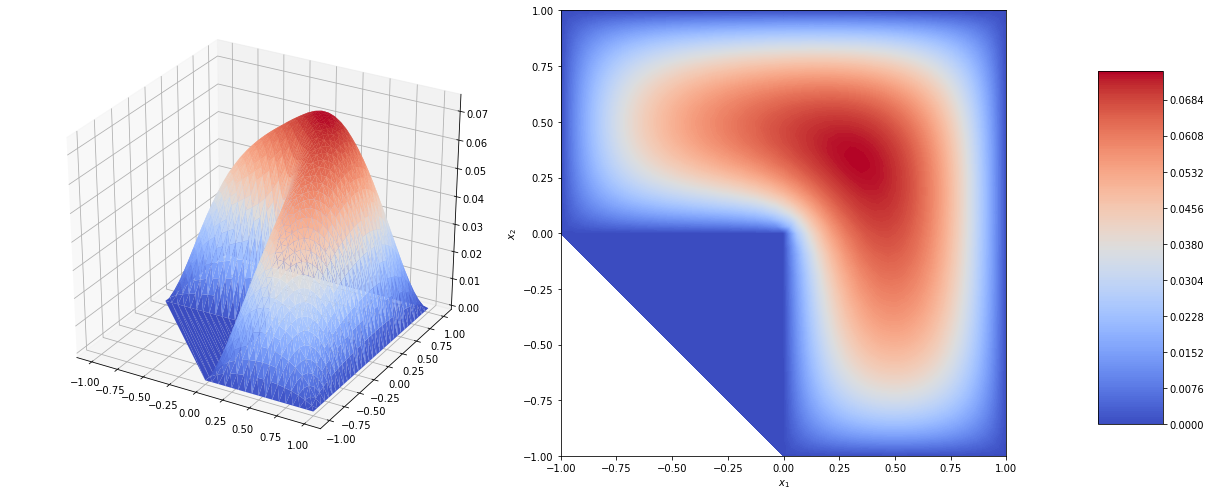

In [8]:
fes_ones = FiniteElementSolver('lshape.vtk', 'float64')
x = fes_ones.Mesh.vertex_arr[:, 0]
y = fes_ones.Mesh.vertex_arr[:, 1]
f = np.ones(len(x))
fes_ones.Plot(tol=1E-5, opencl=True, f=f)

The right hand side can be modified to be anything we like, and the class works with a refined mesh (double the elements in this instance):

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x1ea347493e0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


Norm of residual at iteration   320: 1.85949647044e-06

Exit status: 0
Iterations:  320


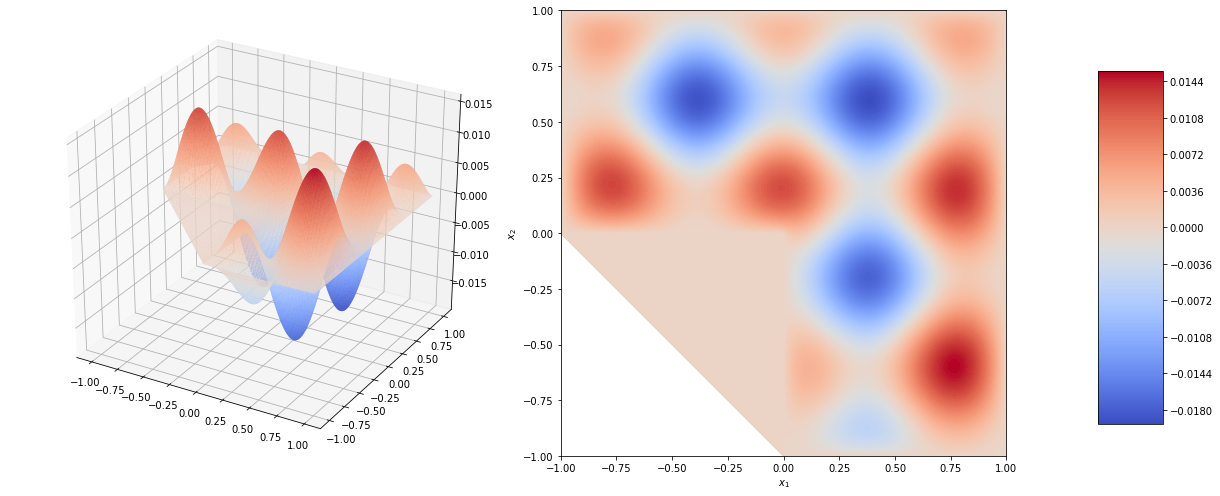

In [9]:
if not MARKING_VERSION:
    fes_interesting = FiniteElementSolver('lshape_refined_4.vtk', 'float64')
    x = fes_interesting.Mesh.vertex_arr[:, 0]
    y = fes_interesting.Mesh.vertex_arr[:, 1]
    f = np.sin(8*y) + np.cos(8*x)
    fes_interesting.Plot(tol=1e-4, opencl=True, f=f)
else:
    display(HTML("""
    <img src="https://i.imgur.com/aVWoAqT.png",width=60,height=60>
    """))

We can also use 32-bit precision:

Norm of residual at iteration     1: 0.120007

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x19bf8112fd0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


Norm of residual at iteration    86: 4.44439e-06

Exit status: 0
Iterations:  86


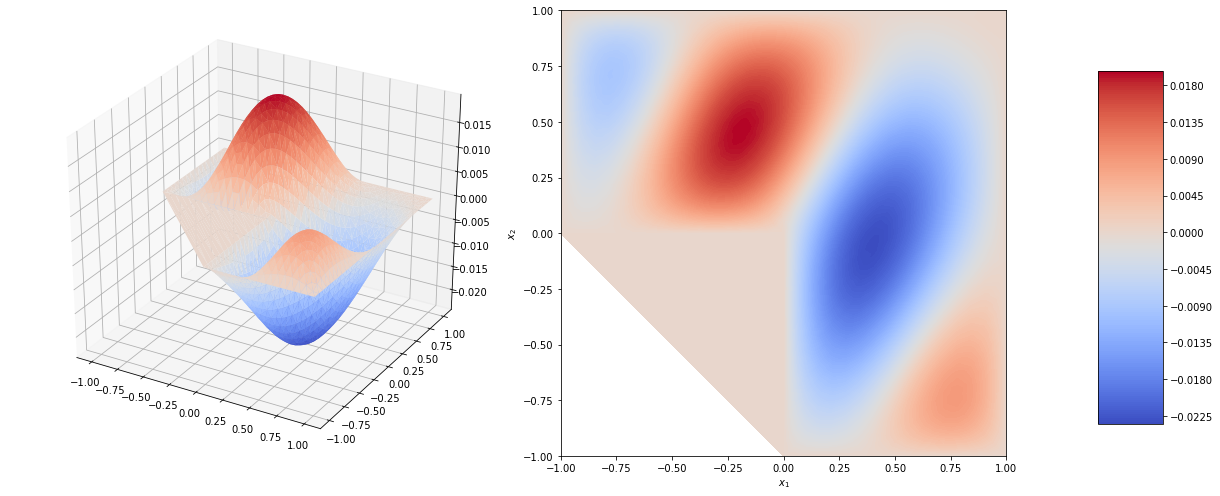

In [10]:
fes_32 = FiniteElementSolver('lshape.vtk', 'float32')
x = fes_32.Mesh.vertex_arr[:, 0]
y = fes_32.Mesh.vertex_arr[:, 1]
f = np.sin(2*y - 4*x) * np.cos(x + y)
fes_32.Plot(tol=1e-4, opencl=True, f=f)

Benchmarking can be seen below. On my computer (Intel HD Graphics 620, Intel Core i7), the parallel version is about 10 times faster than the series (numpy) version.

In [11]:
Trials = 1
FES = FiniteElementSolver('lshape.vtk', 'float64')
with Timer() as t:
    for _ in range(Trials):
        s = ' '*(4-len(str(_+1)))
        s2 = ' '*(4-len(str(Trials)))
        sys.stdout.flush()
        sys.stdout.write("\rTrial " + str(_+1) + s +
                         ' of' + s2 + str(Trials) + ' (OpenCL)')
        FES.CGSolve(tol=1E-5, opencl=True, suppress=True)

print('\n')
with Timer() as b:
    for _ in range(Trials):
        s = ' '*(4-len(str(_+1)))
        s2 = ' '*(4-len(str(Trials)))
        sys.stdout.flush()
        sys.stdout.write("\rTrial " + str(_+1) + s +
                         ' of' + s2 + str(Trials) + ' (Numpy)')
        FES.CGSolve(tol=1E-5, opencl=False, suppress=True)

print("\nOpenCL:", str(t.interval/Trials)[:8])
print("NumPy: ", str(b.interval/Trials)[:8])

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x19bf8112fd0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


Trial 1    of   1 (OpenCL)



Trial 1    of   1 (Numpy)


OpenCL: 1.593998
NumPy:  16.15439


In [12]:
if not MARKING_VERSION: # The python section of this one takes a while!
    Trials = 1
    FES = FiniteElementSolver('lshape_refined_2.vtk', 'float64')
    with Timer() as t:
        for _ in range(Trials):
            s = ' '*(4-len(str(_+1)))
            s2 = ' '*(4-len(str(Trials)))
            sys.stdout.flush()
            sys.stdout.write("\rTrial " + str(_+1) + s +
                             ' of' + s2 + str(Trials) + ' (OpenCL)')
            FES.CGSolve(tol=1E-5, opencl=True, suppress=True)

    print('\n')
    with Timer() as b:
        for _ in range(Trials):
            s = ' '*(4-len(str(_+1)))
            s2 = ' '*(4-len(str(Trials)))
            sys.stdout.flush()
            sys.stdout.write("\rTrial " + str(_+1) + s +
                             ' of' + s2 + str(Trials) + ' (Numpy)')
            FES.CGSolve(tol=1E-5, opencl=False, suppress=True)

    print("\nOpenCL:", str(t.interval/Trials)[:8])
    print("NumPy: ", str(b.interval/Trials)[:8])

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x19bf8112fd0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


Trial 1    of   1 (OpenCL)



Trial 1    of   1 (Numpy)


OpenCL: 4.688005
NumPy:  121.4993


The plot showing the progression towards the 'correct' value of ```u``` (calculated using 256x as many nodes as in the original vtk file) at coordinates (0.5, 0.5) follows a broadly similar trend to the norm of the residual of the conjugate gradient. The time taken for completion is roughly linear in the number of nodes, whereas the number of iterations goes up with the square root of the number of nodes.

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x19bf8112fd0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


Norm of residual at iteration    75: 6.4388979688e-077

Exit status: 0
Iterations:  75
Norm of residual at iteration   152: 3.68757644005e-07

Exit status: 0
Iterations:  152
Norm of residual at iteration   309: 1.79464932804e-07

Exit status: 0
Iterations:  309
Norm of residual at iteration   625: 9.3207804825e-088

Exit status: 0
Iterations:  625
Norm of residual at iteration  1265: 4.69276235201e-08

Exit status: 0
Iterations:  1265
Norm of residual at iteration    75: 6.4388979688e-077

Exit status: 0
Iterations:  75
Norm of residual at iteration   152: 3.68757644005e-07

Exit status: 0
Iterations:  152
Norm of residual at iteration   309: 1.79464932804e-07

Exit status: 0
Iterations:  309
Norm of residual at iteration   625: 9.3207804825e-088

Exit status: 0
Iterations:  625
Norm of residual at iteration  1265: 4.69276235201e-08

Exit status: 0
Iterations:  1265
Original mesh:     3.1449
4x as many nodes:  11.277
16x as many nodes: 50.414
64x as many nodes: 357.41
256x as many nod

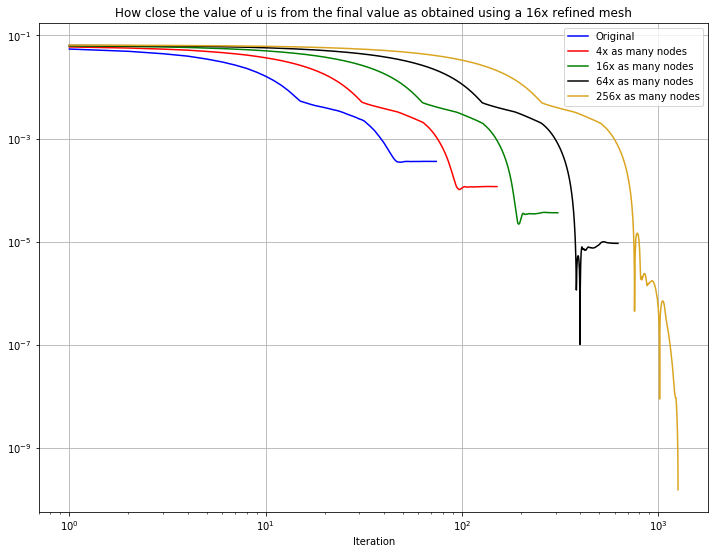

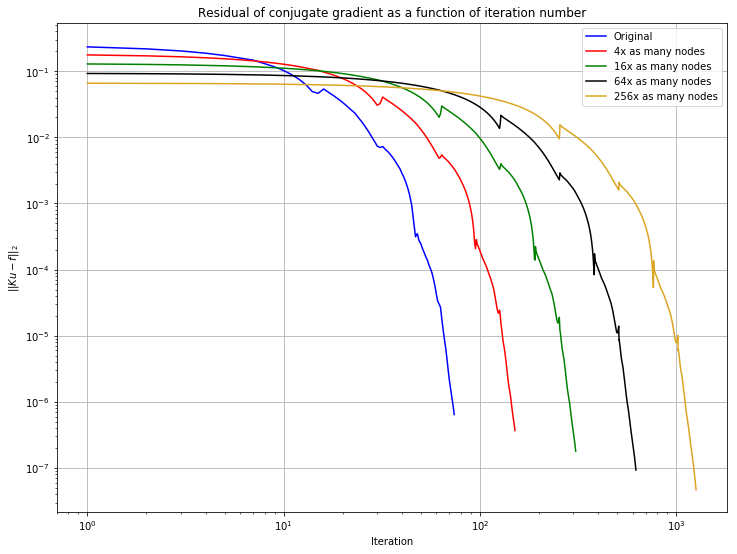

In [ ]:
if not MARKING_VERSION:
    fes_refined_1 = FiniteElementSolver('lshape.vtk', 'float64')
    fes_refined_2 = FiniteElementSolver('lshape_refined_2.vtk', 'float64')
    fes_refined_4 = FiniteElementSolver('lshape_refined_4.vtk', 'float64')
    fes_refined_8 = FiniteElementSolver('lshape_refined_8.vtk', 'float64')
    fes_refined_16 = FiniteElementSolver('lshape_refined_16.vtk', 'float64')

    # for timing, suppress recording of extra info which causes significant slowdown
    with Timer() as a:
        fes_refined_1.CGSolve(tol=1e-5, suppress=False)
    with Timer() as b:
        fes_refined_2.CGSolve(tol=1e-5, suppress=False)
    with Timer() as c:
        fes_refined_4.CGSolve(tol=1e-5, suppress=False)
    with Timer() as d:
        fes_refined_8.CGSolve(tol=1e-5, suppress=False)
    with Timer() as e:
        fes_refined_16.CGSolve(tol=1e-5, suppress=False)
    
    # For CG, must take slower 'non-suppressed' route which records residuals
    fes_refined_1.CGSolve(tol=1e-5)
    fes_refined_2.CGSolve(tol=1e-5)
    fes_refined_4.CGSolve(tol=1e-5)
    fes_refined_8.CGSolve(tol=1e-5)
    fes_refined_16.CGSolve(tol=1e-5)
    

    
    plt.loglog(list(range(len(fes_refined_1.pt_history))), fes_refined_1.pt_history, 'b-', label='Original')
    plt.loglog(list(range(len(fes_refined_2.pt_history))), fes_refined_2.pt_history, 'r-', label='4x as many nodes')
    plt.loglog(list(range(len(fes_refined_4.pt_history))), fes_refined_4.pt_history, 'g-', label='16x as many nodes')
    plt.loglog(list(range(len(fes_refined_8.pt_history))), fes_refined_8.pt_history, 'k-', label='64x as many nodes')
    plt.loglog(list(range(len(fes_refined_16.pt_history[:-1]))), fes_refined_16.pt_history[:-1], '-', color='goldenrod', label='256x as many nodes')
    plt.legend()
    plt.grid(True)
    plt.xlabel('Iteration')
    plt.ylabel('')
    plt.title('How close the value of u is from the final value as obtained using a 16x refined mesh')
    plt.figure()
    plt.loglog(list(range(len(fes_refined_1.cg_history))), fes_refined_1.cg_history, 'b-', label='Original')
    plt.loglog(list(range(len(fes_refined_2.cg_history))), fes_refined_2.cg_history, 'r-', label='4x as many nodes')
    plt.loglog(list(range(len(fes_refined_4.cg_history))), fes_refined_4.cg_history, 'g-', label='16x as many nodes')
    plt.loglog(list(range(len(fes_refined_8.cg_history))), fes_refined_8.cg_history, 'k-', label='64x as many nodes')
    plt.loglog(list(range(len(fes_refined_16.cg_history))), fes_refined_16.cg_history,  '-', color='goldenrod', label='256x as many nodes')
    plt.legend()
    plt.grid(True)
    plt.xlabel('Iteration')
    plt.ylabel(r'$||Ku - f||_2$')
    plt.title('Residual of conjugate gradient as a function of iteration number')
    print('Original mesh:    ', str(a.interval)[:6])
    print('4x as many nodes: ', str(b.interval)[:6])
    print('16x as many nodes:', str(c.interval)[:6])
    print('64x as many nodes:', str(d.interval)[:6])
    print('256x as many nodes:', str(e.interval)[:6])
else:
    display(HTML("""
    <img src="https://i.imgur.com/nnvxzHm.png",width=60,height=60>
    <img src="https://i.imgur.com/R7SIOxN.png",width=60,height=60>
    <img src="https://i.imgur.com/qH8o8hn.png">
    """))

## Phase 3: Time Dependence

The evolution of the problem in time is modelled by a crude forward euler method. Local M has been calculated by hand, and is constant so has been calculated outside of the loop using numpy and a vector of diagonals of its 'lumpy' cousin fed into the 3rd kernel. Any choice of time step above $7 \times 10^{-5}$ was found to be unstable (example below); $5 \times 10^{-5}$ was chosen to be safe.

The time taken to calculate the values of u at each time step is dwarfed by the time taken to render each frame of the animated plots. The benchmarking is therefore done with far more iterations than the plot-generation due to time constraints. The code is disabled for marking, but generated videos are embedded.

In [25]:
def dynamic_2d(filename, dtype, dt, frames, tol=1e-5, f=-1):
    plt.clf()
    matplotlib.rcParams['figure.figsize'] = (12, 9)
    fes = FiniteElementSolver(filename, dtype)
    if type(f) == int:
        f = np.ones((fes.Mesh.vertex_arr.shape[0]))
    results = fes.phase_3(fes.CGSolve(tol, f=f), dt, n_iters=frames, ocl=True)
    res_len = results.shape[0]
    X = fes.Mesh.vertex_arr[:, 0]
    Y = fes.Mesh.vertex_arr[:, 1]
    soln = results[:, 0]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    v = np.amax(results)
    vmin = np.amin(results)
    surf = ax.tricontourf(X, Y, soln, 50, cmap=cm.coolwarm, vmin=vmin, vmax=v)#, shade=False, cmap=cm.coolwarm, linewidth=0)
    fig.colorbar(surf, aspect=9)
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.gca().set_aspect('equal', adjustable='box')

    def data_gen(framenumber, soln, plot):
        s = ' '*(5-len(str(framenumber)))
        sys.stdout.write("\rRendering frame: " + s + str(framenumber) +
                         ' of ' + str(frames))
        sys.stdout.flush()
        soln = results[:, framenumber]
        surf = ax.tricontourf(X, Y, soln, 100, cmap=cm.coolwarm, vmin=vmin, vmax=v)
        plt.close()
        return surf
    
    anim = animation.FuncAnimation(fig, data_gen, fargs=(soln, surf), frames=results.shape[1],
                              interval=50, blit=False)
    return anim

In [26]:
if not MARKING_VERSION:
    fes = FiniteElementSolver('lshape.vtk', 'float64')
    display(HTML(dynamic_2d('lshape.vtk', 'float64', tol=1e-5, dt=0.00005, frames=150).to_html5_video()))
else:
    display(HTML("""
    <div align="middle">
    <video width="80%" controls autoplay loop>
        <source src="https://i.imgur.com/RXVP4KA.mp4" type="video/mp4">
    </video></div>
    """))

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x19bf8112fd0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


Norm of residual at iteration    75: 6.4388979688e-077

Exit status: 0
Iterations:  75
Rendering frame:   150 of 150

In [25]:
def simple_3d(filename, dtype, dt, frames, tol=1e-5, f=-1, jitter=False):
    matplotlib.rcParams['figure.figsize'] = (9, 9)
    fes = FiniteElementSolver(filename, dtype)
    if jitter:
        frames *= 8
    results = fes.phase_3(fes.CGSolve(tol, f=f), dt, n_iters=frames, ocl=True)
    if jitter:
        frames /= 8
    res_len = results.shape[0]
    X = fes.Mesh.vertex_arr[:, 0]
    Y = fes.Mesh.vertex_arr[:, 1]
    vmax = np.amax(results)
    vmin = np.amin(results)
    if type(f) == int:
        f = np.ones((fes.Mesh.vertex_arr.shape[0]))
    
    fig = plt.figure()
    images = []
    frames = int(frames)
    for i in range(frames):
        s = ' '*(5-len(str(i+1)))
        sys.stdout.write("\rRendering frame: " + s + str(i+1) +
                         ' of ' + str(frames))
        sys.stdout.flush()
        axes = fig.gca(projection='3d')
        idx = i*8 if jitter else i
        try:
            images.append([axes.plot_trisurf(X, Y, results[:, idx], shade=False, cmap=cm.coolwarm,
                                             linewidth=0, vmax=vmax, vmin=vmin)])
        except Exception:
            pass # For jitter
        plt.close()
    anim = animation.ArtistAnimation(fig, images, interval=50 if jitter else 35, blit=True, repeat_delay=500)
    return anim

In [63]:
if not MARKING_VERSION:
    display(HTML(simple_3d('lshape.vtk', 'float64', tol=1e-5, dt=0.00005, frames=120).to_html5_video()))
else:
    display(HTML("""
    <div align="middle">
    <video width="80%" controls autoplay loop>
        <source src="https://i.imgur.com/zxqqfDS.mp4" type="video/mp4">
    </video></div>
    """))

Norm of residual at iteration     2: 0.233082129237

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x19bf8112fd0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


Norm of residual at iteration    75: 6.4388979688e-077

Exit status: 0
Iterations:  75
Rendering frame:   120 of 120

We can also do some slightly more interesting right hand sides to create peaks and troughs. The local areas of high and low temperature equalise out as expected, as the overall temperature tends towards 0 K.

In [64]:
if not MARKING_VERSION:
    fes = FiniteElementSolver('lshape.vtk', 'float64')
    x = fes.Mesh.vertex_arr[:, 0]
    y = fes.Mesh.vertex_arr[:, 1]
    f = np.sin(8*x) - np.cos(8*y)
    display(HTML(simple_3d('lshape.vtk', 'float64', tol=1e-5, dt=0.00005, frames=120, f=f).to_html5_video()))
    f = np.sin(2*y - 4*x) * np.cos(x + y)
    display(HTML(simple_3d('lshape.vtk', 'float64', tol=1e-5, dt=0.00005, frames=120, f=f).to_html5_video()))
else:
    display(HTML("""
    <div align="middle">
    <video width="80%" controls autoplay loop>
        <source src="https://i.imgur.com/lzAWTKD.mp4" type="video/mp4">
    </video></div>
    <div align="middle">
    <video width="80%" controls autoplay loop>
        <source src="https://i.imgur.com/2GBZQ6I.mp4" type="video/mp4">
    </video></div>
    """))

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x19bf8112fd0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


Norm of residual at iteration    98: 7.1324345776e-077

Exit status: 0
Iterations:  98
Rendering frame:   120 of 120

Norm of residual at iteration    99: 4.19242993716e-07

Exit status: 0
Iterations:  99
Rendering frame:   120 of 120

Below is an example of the animation function in action (with a small number of frames to reduce running time for marking):

In [26]:
if MARKING_VERSION:    
    fes = FiniteElementSolver('lshape.vtk', 'float64')
    x = fes.Mesh.vertex_arr[:, 0]
    y = fes.Mesh.vertex_arr[:, 1]
    f = x
    display(HTML(simple_3d('lshape.vtk', 'float64', tol=1e-5, dt=0.00005, frames=10, f=f, jitter=True).to_html5_video()))

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x1ea347493e0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)


Norm of residual at iteration   101: 4.05584885764e-07

Exit status: 0
Iterations:  101
Rendering frame:    10 of 10

The number of timesteps per second is 103 when using opencl and 35 when using numpy (which still uses the OpenCL version of MatVec). The benifit of OpenCL over Python is diminished with finer meshes, because the bottleneck is in the 3rd kernel (```sumY```), which is not parallelised (because parallelising would introduce race conditions). Increasing the number of nodes causes this bottleneck to become more dominant, to the point where performance is comparable to that of the reasonably efficient numpy vector operations.

In [24]:
if not MARKING_VERSION:    
    fes = FiniteElementSolver('lshape.vtk', 'float64')
    iters = 100
    res, tm1 = fes.phase_3(fes.CGSolve(1e-5, suppress=True), 0.00005, n_iters=iters, ocl=True, timer=True)
    res, tm_py1 = fes.phase_3(fes.CGSolve(1e-5, suppress=True), 0.00005, n_iters=iters, ocl=False, timer=True)
    fes = FiniteElementSolver('lshape_refined_2.vtk', 'float64')
    res, tm2 = fes.phase_3(fes.CGSolve(1e-5, suppress=True), 0.00005, n_iters=iters, ocl=True, timer=True)
    res, tm_py2 = fes.phase_3(fes.CGSolve(1e-5, suppress=True), 0.00005, n_iters=iters, ocl=False, timer=True)
    fes = FiniteElementSolver('lshape_refined_4.vtk', 'float64')
    res, tm3 = fes.phase_3(fes.CGSolve(1e-5, suppress=True), 0.00005, n_iters=iters, ocl=True, timer=True)
    res, tm_py3 = fes.phase_3(fes.CGSolve(1e-5, suppress=True), 0.00005, n_iters=iters, ocl=False, timer=True)
    print('Iterations per second (OpenCL, 1x nodes): \t', str(iters/tm1)[:6])
    print('Iterations per second (Numpy, 1x nodes):  \t', str(iters/tm_py1)[:6])
    print('Iterations per second (OpenCL, 4x nodes):\t', str(iters/tm2)[:6])
    print('Iterations per second (Numpy, 4x nodes): \t', str(iters/tm_py2)[:6])
    print('Iterations per second (OpenCL, 16x nodes):\t', str(iters/tm3)[:6])
    print('Iterations per second (Numpy, 16x nodes): \t', str(iters/tm_py3)[:6])
else:
    display(HTML("""
    <img src="https://i.imgur.com/mkFkwSJ.png",width=60,height=60>
    """))

C:\Users\Jack\Anaconda3\lib\site-packages\pyopencl\cffi_cl.py:1517: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) HD Graphics 620' on 'Intel(R) OpenCL' at 0x1ea347493e0> succeeded, but said:

fcl build 1 succeeded.
bcl build succeeded.

  warn(text, CompilerWarning)
C:\Users\Jack\Anaconda3\lib\site-packages\ipykernel_launcher.py:384: RuntimeWarning: overflow encountered in multiply
C:\Users\Jack\Anaconda3\lib\site-packages\ipykernel_launcher.py:384: RuntimeWarning: invalid value encountered in subtract


Iterations per second (OpenCL, 1x nodes): 	 103.75
Iterations per second (Numpy, 1x nodes):  	 35.811
Iterations per second (OpenCL, 4x nodes):	 39.910
Iterations per second (Numpy, 4x nodes): 	 16.173
Iterations per second (OpenCL, 16x nodes):	 15.003
Iterations per second (Numpy, 16x nodes): 	 9.7881
